# <a id='toc1_'></a>[Notebook de modelisation](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Notebook de modelisation](#toc1_)    
  - [Setup models](#toc1_1_)    
  - [Lecture des données](#toc1_2_)    
  - [Fonctions](#toc1_3_)    
- [Model Initial](#toc2_)    
- [Weekly models](#toc3_)    
- [Ajusted Rand Index](#toc4_)    
- [Conclusion](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
# Imports des librairies
import pandas as pd
import numpy as np
from sklearn import cluster, metrics, mixture
from sklearn.datasets import make_blobs
import time
import hdbscan  # Pour HDBSCAN
from joblib import Parallel, delayed
import os

import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
import joblib
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

## <a id='toc1_1_'></a>[Setup models](#toc0_)

In [ ]:
# Initialisation des modèles dispo a partir du benchmark
def set_models_params(n_cluster_value=5, min_sample_value=1000):
    model_list = {
        'kmeans': cluster.KMeans(n_clusters=n_cluster_value),
        'minibatchkmeans': cluster.MiniBatchKMeans(n_clusters=n_cluster_value),
        'birch': cluster.Birch(n_clusters=n_cluster_value),
    }
    return model_list

model_list = set_models_params()

## <a id='toc1_2_'></a>[Lecture des données](#toc0_)

In [ ]:
# Lecture des données
try:
    rfmls_origin = pd.read_csv('/content/drive/MyDrive/Notebook Colab/Projet5_olist/RFMLS.csv')
except FileNotFoundError:
    print("Fichier non trouvé dans Google Drive. Tentative de chargement depuis un autre chemin...")
    try:
        rfmls_origin = pd.read_csv('./RFMLS.csv')
        print('Sucessfuly Load from local directory')
    except FileNotFoundError:
        print("Fichier non trouvé dans le chemin local. Veuillez vérifier les chemins.")
        raise

rfmls = rfmls_origin.copy()
rfmls.head()

Fichier non trouvé dans Google Drive. Tentative de chargement depuis un autre chemin...
Sucessfuly Load from local directory


,Unnamed: 0,order_purchase_timestamp,R,F,M,S,L,Segment
0,0,2018-05-10 10:56:27,1847,1,141.90,5,cajamar,Perdus
1,1,2018-05-07 11:11:27,1850,1,27.19,4,osasco,Perdus
2,2,2017-03-10 21:05:03,2273,1,86.22,3,sao jose,Perdus
3,3,2017-10-12 20:29:41,2057,1,43.62,4,belem,Perdus
4,4,2017-11-14 19:45:42,2024,1,196.89,5,sorocaba,Perdus


## <a id='toc1_3_'></a>[Fonctions](#toc0_)

In [ ]:
def process_data(data, train_scaler=False):
    """AI is creating summary for process_data

    Args:
        data (dataframe): un dataframe pandas qui contient les colonnes RFMLS
        train_scaler (bool, optional):

    Raises:
        ValueError: Si les données ne sont pas présentent
        FileNotFoundError: Si le fichier du scaler n'est pas trouvé

    Returns:
        [dataframe]: a processed dataframe
    """
    # Suppression des valeurs manquantes
    data = data.dropna()

    # Convertir la colonne timestamp en datetime
    if "order_purchase_timestamp" in data.columns:
        data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])

    # Mettre la frequence d'apparition
    data["L_freq"] = data.groupby("L")["L"].transform("count") / len(data["L"])

    # Sélection des features
    features = ["R", "F", "M", "S", "L_freq"]

    if not all(col in data.columns for col in features):
        raise ValueError(
            f"Les colonnes suivantes sont manquantes : {set(features) - set(data.columns)}"
        )

    if train_scaler:
        scaler = StandardScaler().fit(data[features])
        joblib.dump(scaler, "scaler.pkl")
    else:
        if not train_scaler and not os.path.exists("scaler.pkl"):
            raise FileNotFoundError(
                "Le fichier 'scaler.pkl' n'existe pas. Entraînez d'abord le scaler."
            )
        scaler = joblib.load("scaler.pkl")
        data[features] = scaler.transform(data[features])

    return data[features]

In [ ]:
def visualize_tsne(data, labels=None, perplexity=30, n_components=2, random_state=42):
    """
    Génère une visualisation t-SNE des données.
    
    Args :
    - data : DataFrame ou array-like, les données à visualiser.
    - labels : array-like, étiquettes des clusters (optionnel, pour colorer les points).
    - perplexity : float, paramètre de perplexité pour t-SNE (par défaut : 30).
    - n_components : int, nombre de dimensions de sortie (2 ou 3, par défaut : 2).
    - random_state : int, graine aléatoire pour la reproductibilité (par défaut : 42).
    
    Return :
    - Un graphique t-SNE en 2D ou 3D.
    """
    # Vérifiez si les données sont déjà normalisées
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)  # Normalisez les données
    
    # Appliquez t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    tsne_results = tsne.fit_transform(data_scaled)
    
    # Visualisation
    if n_components == 2:
        plt.figure(figsize=(10, 8))
        if labels is not None:
            scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
            plt.colorbar(scatter, label='Cluster')
        else:
            plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=50, alpha=0.7)
        plt.title("Visualisation t-SNE (2D)")
        plt.xlabel("Composante 1")
        plt.ylabel("Composante 2")
        plt.grid(True)
        plt.show()
    
    elif n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        if labels is not None:
            scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], c=labels, cmap='viridis', s=50, alpha=0.7)
            fig.colorbar(scatter, ax=ax, label='Cluster')
        else:
            ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], s=50, alpha=0.7)
        ax.set_title("Visualisation t-SNE (3D)")
        ax.set_xlabel("Composante 1")
        ax.set_ylabel("Composante 2")
        ax.set_zlabel("Composante 3")
        plt.show()
    
    else:
        raise ValueError("Le paramètre 'n_components' doit être 2 ou 3.")

# <a id='toc2_'></a>[Model Initial](#toc0_)

In [ ]:
# Trouver la date minimal dans le dataframe
date_min = rfmls['order_purchase_timestamp'].min()
print(date_min)

# DAte max dans le df
date_max = rfmls['order_purchase_timestamp'].max()
print(date_max)

2016-09-04 21:15:19
2018-10-17 17:30:18


In [ ]:
# Recuperer toutes les données de la premiere année d'activite
df_first_year = rfmls[rfmls['order_purchase_timestamp'] < '2017-09-04']
print("Longeur du df: ",len(df_first_year))
df_first_year.head()

In [28]:
# Entrainement & Enregistrement du scaler
process_data(df_first_year, train_scaler=True)

,R,F,M,S,L_freq
2,2273,1,86.22,3,0.001843
8,2279,1,150.12,4,0.000944
10,2143,1,29.00,3,0.000225
14,2119,1,91.28,4,0.015600
18,2113,1,257.44,2,0.000629
...,...,...,...,...,...
95364,2119,1,102.74,5,0.018432
95367,2098,1,55.00,4,0.005979
95374,2183,1,2067.42,5,0.000090
95376,2304,1,112.46,5,0.000315


In [29]:
# transformation des données avec le scaler entrainé avant
first_year_process = process_data(df_first_year, train_scaler=False)
first_year_process.describe()

,R,F,M,S,L_freq
count,2.224400e+04,2.224400e+04,2.224400e+04,2.224400e+04,2.224400e+04
mean,5.110899e-17,5.134856e-16,1.143564e-16,1.354388e-16,8.305211e-18
std,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00
min,-1.460299e+00,-1.537231e-01,-6.387916e-01,-1.920850e+00,-5.635362e-01
25%,-8.359598e-01,-1.537231e-01,-4.308270e-01,-1.591865e-01,-5.538630e-01
50%,-1.099839e-01,-1.537231e-01,-2.505177e-01,4.280348e-01,-5.122685e-01
75%,7.321482e-01,-1.537231e-01,5.643957e-02,4.280348e-01,-2.288455e-01
max,3.824806e+00,2.782842e+01,3.073017e+01,1.510857e+01,2.334537e+00


In [30]:
model_initial = model_list['kmeans']
labels_initial = model_initial.fit_predict(first_year_process)

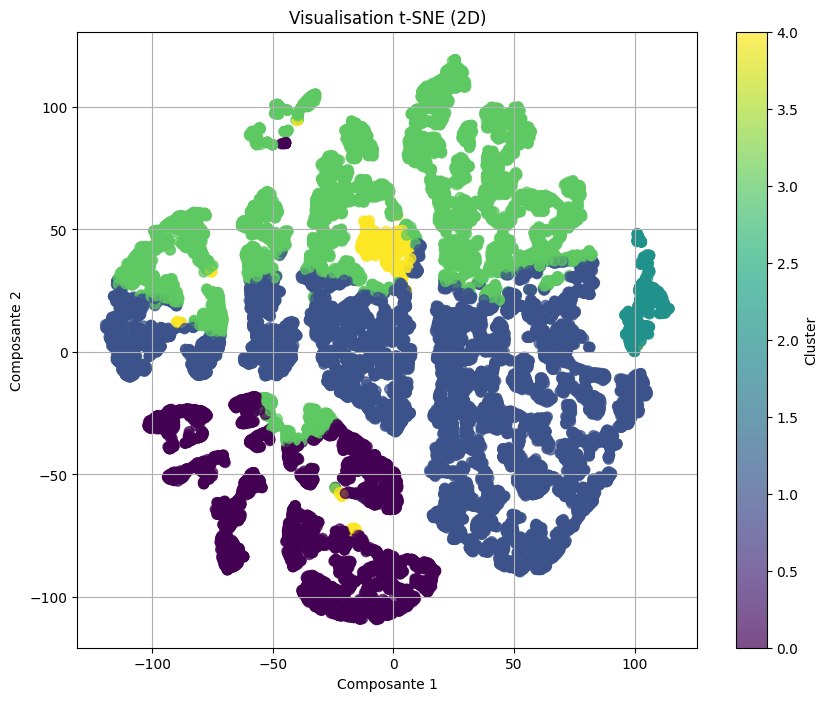

In [ ]:
# plot le resultat 
visualize_tsne(data=first_year_process, labels=labels_initial, perplexity=30, n_components=2)

# <a id='toc3_'></a>[Weekly models](#toc0_)

In [ ]:
# Tout ce qu il y a apres la premiere année
df_new_data = rfmls[rfmls['order_purchase_timestamp'] > '2017-09-04']
print(len(df_new_data))
df_new_data.head()

73135


,Unnamed: 0,order_purchase_timestamp,R,F,M,S,L,Segment
0,0,2018-05-10 10:56:27,1847,1,141.90,5,cajamar,Perdus
1,1,2018-05-07 11:11:27,1850,1,27.19,4,osasco,Perdus
3,3,2017-10-12 20:29:41,2057,1,43.62,4,belem,Perdus
4,4,2017-11-14 19:45:42,2024,1,196.89,5,sorocaba,Perdus
5,5,2018-04-05 19:33:16,1882,1,166.98,4,sao paulo,Perdus


In [ ]:
import pandas as pd

# conversion en datetime
rfmls['order_purchase_timestamp'] = pd.to_datetime(rfmls['order_purchase_timestamp'])

# setup la colonne comme index
df_new_data = rfmls[rfmls['order_purchase_timestamp'] > '2017-09-04'].set_index('order_purchase_timestamp')

# trier les données par ordre chronologique
df_new_data = df_new_data.sort_index()

# regrouper les données par semaine
weekly_groups = df_new_data.groupby(pd.Grouper(freq='W'))

# liste de DataFrames hebdomadaires
weekly_dfs = [group for _, group in weekly_groups if not group.empty]  # Ignorer les semaines vides

# reinitialiser les modèle precedant
set_models_params()

    
#  Liste pour stocker les résultats
results = []

# Boucle sur les DataFrames hebdomadaires
for i, weekly_df in enumerate(weekly_dfs):
    # Prétraitement des données hebdomadaires
    weekly_processed = process_data(weekly_df, train_scaler=False)
    
    # Vérifier si pas null
    if len(weekly_processed) == 0:
        print(f"Semaine {i + 1} : Aucune donnée disponible après prétraitement.")
        continue
    
    # concatenation des datas
    combined_data = pd.concat([first_year_process, weekly_processed])
    
    # train d'un nouveau modèle les data de la semaine
    weekly_model = cluster.KMeans(n_clusters=model_initial.n_clusters)
    weekly_labels_combined = weekly_model.fit_predict(combined_data)
    
    # recuperer les labels correspondant aux données hebdomadaires
    weekly_labels = weekly_labels_combined[-len(weekly_processed):]
    
    # prediction des clusters de la semaine avec le model initale
    labels_initial_weekly = model_initial.predict(weekly_processed)
    
    # calcul de l'ARI entre les clusters initial vs weekly
    ari = adjusted_rand_score(labels_initial_weekly, weekly_labels)
    
    # Stockage des résultats
    results.append({
        "week": i + 1,
        "num_points": len(weekly_processed),
        "ari": ari
    })
    
    # Affichage des résultats pour chaque semaine
    # print(f"Semaine {i + 1} : Nombre de points = {len(weekly_processed)}, ARI = {ari}")

# Convertir les résultats en DataFrame pour analyse
results_df = pd.DataFrame(results)
results_df.head()

,week,num_points,ari
0,1,848,0.975304
1,2,1086,1.000000
2,3,938,0.645074
3,4,925,0.995776
4,5,948,0.736016


# <a id='toc4_'></a>[Ajusted Rand Index](#toc0_)

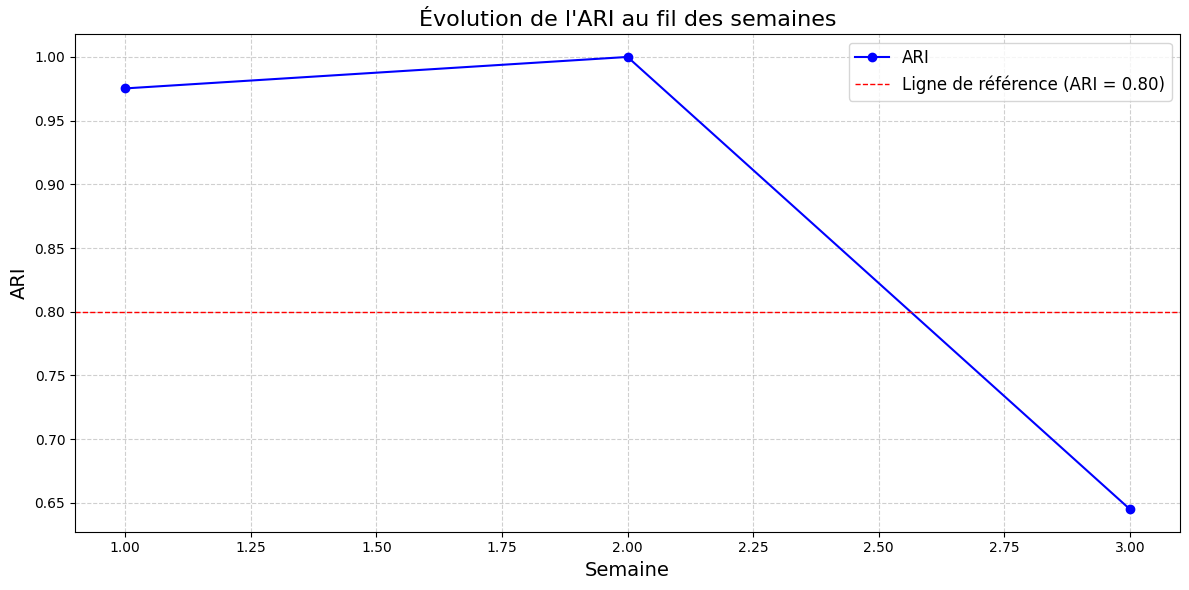

In [ ]:
import matplotlib.pyplot as plt

def plot_ari_interval(results_df, week_range=None):
    """
    Affiche un graphique montrant l'évolution de l'ARI au fil des semaines dans un intervalle spécifié.
    
    Args :
    - results_df : DataFrame contenant les résultats (colonnes : 'week', 'num_points', 'ari').
    - week_range : Tuple (start_week, end_week) définissant l'intervalle de semaines à afficher.
                   Si None, toutes les semaines sont affichées.
    
    Reutrn:
    Un plot de l'ari en fonction des semaines
    """
    # Filtrer les résultats si week_range est spécifié
    if week_range is not None:
        start_week, end_week = week_range
        results_df = results_df[(results_df['week'] >= start_week) & (results_df['week'] <= end_week)]
    
    # Créer le graphique
    plt.figure(figsize=(12, 6))
    
    # Tracer l'évolution de l'ARI
    plt.plot(results_df['week'], results_df['ari'], marker='o', label="ARI", color='blue')
    
    # Ajouter une ligne rouge en pointillés à 0.80
    plt.axhline(y=0.80, color='red', linestyle='--', linewidth=1, label="Ligne de référence (ARI = 0.80)")
    
    # Ajouter des titres et étiquettes
    plt.title("Évolution de l'ARI au fil des semaines", fontsize=16)
    plt.xlabel("Semaine", fontsize=14)
    plt.ylabel("ARI", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Ajouter une légende
    plt.legend(fontsize=12)
    
    # Afficher le graphique
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
# Afficher les semaines entre 3 et 8 incluses
plot_ari_interval(results_df, week_range=(1, 3))

# <a id='toc5_'></a>[Conclusion](#toc0_)

D'apres les recherches precedante on peut voir une diminution de l'ari ~ toutes les 3 semaines puis un regain, il serai donc de réentrainer le modèle tous les 15 jours afins d'eviter toutes perte de precision sur le modèle et ne pas engendrer des cout supplementaire injustifier a l'entreprise